In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

from IPython.display import Image
# from IPython.core.display import HTML 

In [2]:
def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)  
    return dot

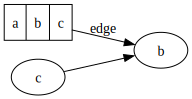

In [3]:
dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 
dot.node('a', label='{a|b|c}', shape='record')
dot.edge('a', 'b', label='edge')
dot.edge('c', 'b')
dot

In [4]:
xs = np.arange(-5, 5, 0.25)

# Tanh

$tanh x = \frac{e^{2x}-1}{e^{2x}+1}$

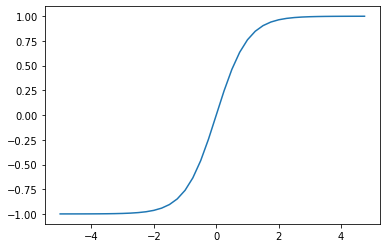

In [5]:
plt.plot(xs, np.tanh(xs))

# EXP

Derivative of an expotent is itself (close to)

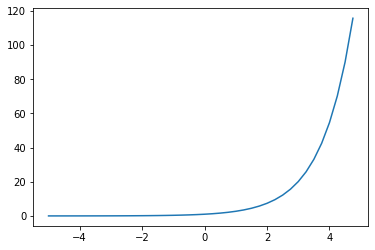

In [6]:
plt.plot(xs, np.exp(xs))

In [7]:
h = 0.01
x = 2
print(np.exp(x))
print((np.exp(x+h) - np.exp(x))/h)

7.38905609893065
7.426124838854253


# f(x)

In [8]:
def f(x):
    return 3*x**2 - 4*x+5

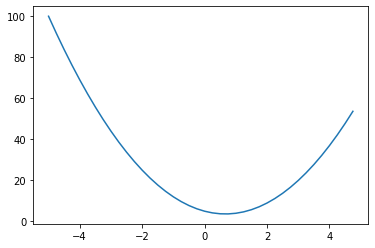

In [9]:
plt.plot(xs, f(xs))

$\frac{dy}{dx}= \frac{f(x+h)-f(x)}{h}$

In [10]:
h = 0.0000000000001
x = 3

(f(x+h)-f(x))/h

13.997691894473974

$\frac{f(a+h)*b-f(a)*b}{h}$

$\frac{ab+ah-ab}{h} = b$

***********

a*b

(1)*b =b

$\frac{a+(c+h)-(a+c)}{h}$

$\frac{a+c+h-a-c)}{h}$

$\frac{h}{h} = 1$

***********

a+c

(1)+(0) =1

In [11]:
h = 0.01
a = 2
b = -3
c = 10
d = a*b + c

d1 = ((a+h)*b+c)
d2 = (a*b+c)
print((d1 - d2)/h)

d1 = (a*(b+h)+c)
print((d1 - d2)/h)

d1 = (a*b+(c+h))
print((d1 - d2)/h)

-2.999999999999936
1.9999999999999574
0.9999999999999787


# Value

In [12]:
class Value:
    def __init__(self, data, children=(), op="", label=""):
        self.data = data
        self._prev = children
        self._op = op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += (1 * other.data) * out.grad
            other.grad += (1 * self.data) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    # derivative of exp is itself
    def exp(self):
        out = Value(np.exp(self.data), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
    def tanh(self):
        t = (np.exp(2 * self.data) - 1) / (np.exp(2 * self.data) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t ** 2) * out.grad 
        out._backward = _backward
        
        return out
    
    # topological sort
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


# Manual Back Propagation

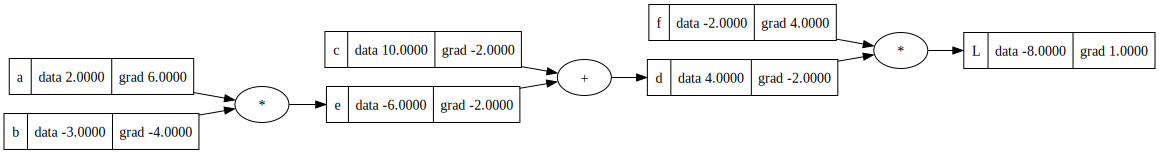

In [13]:

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

L.grad = 1
d.grad = 1 * f.data
f.grad = 1 * d.data
e.grad = (1 + 0) * d.grad
c.grad = (1 + 0) * d.grad
a.grad = (1 * b.data) * e.grad
b.grad = (1 * a.data) * e.grad

draw_dot(L)

# Auto Back Propagation

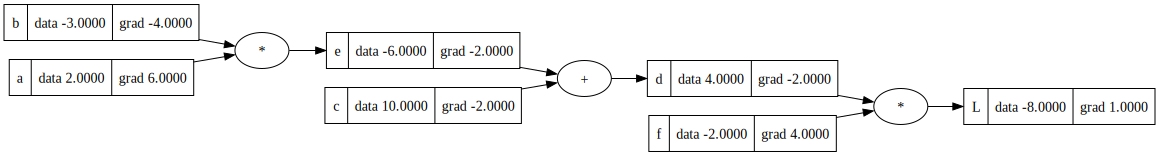

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

# L.grad = 1
# L._backward()
# d._backward()
# e._backward()

L.backward()

draw_dot(L)

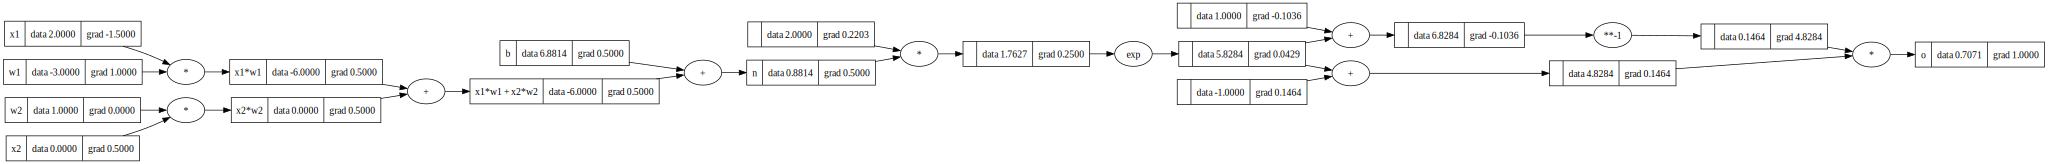

In [15]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

o.backward()
draw_dot(o)

## Bug

(a + b) * (a * b)

In the case of same varibale name occuring twice the grads get replaces coz of the = assignment during backward propagation.

'+' back propagation occurs\
b.grad = -6\
a.grad = -6

'*' back propagation replaces +\
a.grad = 3\
b.grad = -2

---
Fix: Change '=' to '+=' in back propagation\
a.grad = (-6) + (-3) = -3\
b.grad = (-6) + (-2) = -8

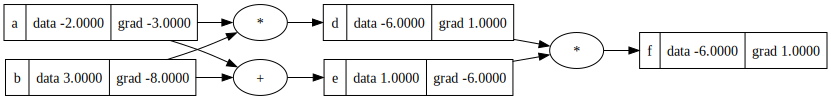

In [16]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()
draw_dot(f)

# Handling Numbers

if not Value convert number to a Value data type\
rmul

In [17]:
a = Value(1)
2 * (a + 2)

value(data=6)

# Torch

In [18]:
import torch

a = torch.Tensor([2]).double()
a.requires_grad=True
b = torch.Tensor([3]).double()
b.requires_grad=True

y = a * b; y.retain_grad()
y.backward()
print(a.grad, b.grad, y.grad)

tensor([3.], dtype=torch.float64) tensor([2.], dtype=torch.float64) tensor([1.], dtype=torch.float64)


In [19]:
Image(url= "https://cs231n.github.io/assets/nn1/neural_net2.jpeg")

In [20]:
class Neuron:
    def __init__(self, nin):
        self.w  = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        act = sum([wi * xi for (wi, xi) in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [21]:
x = [1.0, 2.0]
n = MLP(3, [4,4,1]) # [(3, 4), (4, 4), (4, 1)]
n(x)

value(data=-0.5842768377590217)

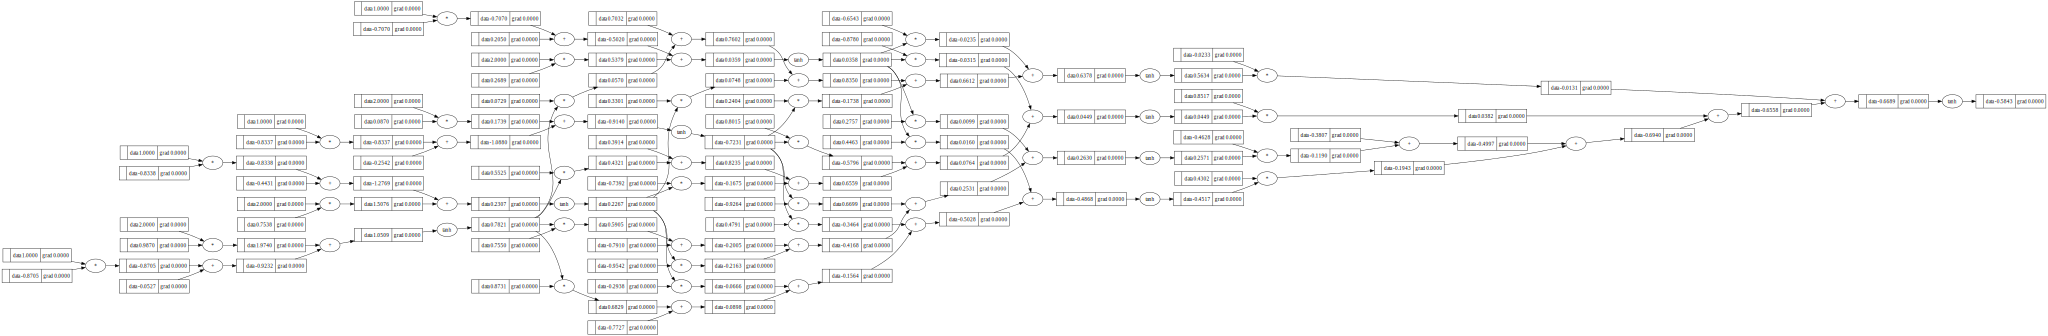

In [22]:
draw_dot(n(x))

In [23]:
xs = [
    [2, 3, -1],
    [3, -1, 0.5],
    [0.5, 1, 1],
    [1, 1, -1]
]

ys = [1, -1, -1, 1]
ypred = [n(x) for x in xs]
ypred

[value(data=-0.6442456296301075),
 value(data=-0.33715176119612744),
 value(data=0.10123238014449566),
 value(data=-0.7756695173079221)]

In [24]:
len(n.parameters())

41

# Graident Descent (Manual)

In [25]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

value(data=7.508626468018363)

In [26]:
for p in n.parameters():
    p.grad = 0
loss.backward()
# draw_dot(loss)

In [27]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [28]:
ypred

[value(data=-0.6442456296301075),
 value(data=-0.33715176119612744),
 value(data=0.10123238014449566),
 value(data=-0.7756695173079221)]

# Gradient Descent (Auto)

In [29]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0
        
    # backward pass
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
        
    print(k, loss.data)

0 6.462361805917177
1 5.363798414530912
2 4.35712067444108
3 3.4921001571600807
4 2.7803143933176147
5 2.223356748051771
6 1.800026122777922
7 1.4797153608543905
8 1.2353669501004207
9 1.046593855126215
10 0.898691405476489
11 0.7811314704732963
12 0.6863584481188462
13 0.6089170962765034
14 0.5448344751914536
15 0.49118629952530457
16 0.44579443269529545
17 0.4070161472828361
18 0.3735968818581717
19 0.3445667079226711


In [30]:
ypred

[value(data=0.7513147436843858),
 value(data=-0.6523099000899106),
 value(data=-0.7530271284827313),
 value(data=0.6824494585535475)]